<a href="https://colab.research.google.com/github/Gorodecki/Projects/blob/master/Regression_HeadHunter_MAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# На базе hh добейтесь средней абсолютной ошибки **не более 12 тысяч**


In [ ]:
import numpy as np #Библиотека работы с массивами
import pandas as pd # Библиотека для работы с базами

from tensorflow.keras.models import Sequential, Model # 
from tensorflow.keras.layers import add, concatenate, Input, Dense, Dropout, BatchNormalization, Flatten #
from tensorflow.keras import utils #Используем для to_categoricall
from tensorflow.keras.optimizers import Adam #
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence #
from tensorflow.keras.preprocessing.sequence import pad_sequences #
from tensorflow.keras.callbacks import LambdaCallback # подключаем колбэки

from sklearn.preprocessing import StandardScaler # 
from sklearn.model_selection import train_test_split # Для разбивки на выборки
from sklearn.metrics import mean_squared_error, mean_absolute_error #
from google.colab import drive #Для загрузки своей картинки

import random #Для генерации случайных чисел 
import math # Для округления
#import os #Для работы с файлами 
import re #
import matplotlib.pyplot as plt #
%matplotlib inline

from IPython.display import clear_output

In [ ]:
drive.mount('/content/drive')
path_to_csv = '/content/drive/Данные/hh_fixed.csv'

# Оценка зарплаты на базе HeadHunter

##Загружаем базу и смотрим содержание

In [ ]:
fixed_df = pd.read_csv(path_to_csv)# Это то, куда вы скачали файл

In [ ]:
# Количество резюме и критерии
print(fixed_df.shape)

(62967, 13)


In [ ]:
fixed_df.head()

,Unnamed: 0,"Пол, возраст",ЗП,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последенее/нынешнее место работы,Последеняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто
0,0,"Мужчина , 29 лет , родился 16 мая 1989",40000 руб.,Специалист по поддержке чата(support team) дом...,"Новороссийск , готов к переезду (Анапа, Геленд...",полная занятость,полный день,Опыт работы 3 года 9 месяцев Специалист по по...,"ООО ""Гольфстрим""",Генеральный директор,Высшее образование 2011 Международный юридиче...,26.04.2019 08:04,Не указано
1,1,"Мужчина , 38 лет , родился 25 мая 1980",40000 руб.,Системный администратор,"Новосибирск , м. Березовая роща , не готов к ...",полная занятость,полный день,Опыт работы 11 лет 11 месяцев Системный админ...,ООО «Завод модульных технологий»,Системный администратор,Высшее образование 2002 Новосибирский государс...,26.04.2019 04:30,Не указано
2,2,"Мужчина , 35 лет , родился 14 июня 1983",300000 руб.,DevOps TeamLead / DevOps архитектор,"Москва , готов к переезду , готов к редким ком...",полная занятость,полный день,Опыт работы 12 лет 11 месяцев DevOps TeamLead...,Банк ВТБ (ПАО),Начальник отдела методологии разработки (DevOp...,DevOps TeamLead / DevOps архитектор 300 000 ру...,09.04.2019 14:40,Не указано
3,3,"Мужчина , 33 года , родился 2 августа 1985",180000 руб.,Руководитель IT отдела,"Москва , м. Щукинская , не готов к переезду ,...","частичная занятость, полная занятость","удаленная работа, полный день",Опыт работы 15 лет 10 месяцев Руководитель IT...,"""Ай-Теко"", ведущий российский системный интегр...",Старший системный администратор,Руководитель IT отдела 180 000 руб. Информацио...,09.04.2019 14:39,Имеется собственный автомобиль
4,4,"Мужчина , 22 года , родился 1 сентября 1996",40000 руб.,Junior Developer,"Москва , м. Юго-Западная , не готов к переезд...","стажировка, частичная занятость, проектная работа","гибкий график, удаленная работа",Опыт работы 1 год 1 месяц Junior Developer 40...,R-Style SoftLab,Менеджер IT-проектов,Junior Developer 40 000 руб. Информационные те...,29.03.2019 12:40,Не указано


In [ ]:
fixed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62967 entries, 0 to 62966
Data columns (total 13 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   Unnamed: 0                                62967 non-null  int64 
 1   Пол, возраст                              62967 non-null  object
 2   ЗП                                        62967 non-null  object
 3   Ищет работу на должность:                 62967 non-null  object
 4   Город                                     62967 non-null  object
 5   Занятость                                 62967 non-null  object
 6   График                                    62967 non-null  object
 7   Опыт (двойное нажатие для полной версии)  62599 non-null  object
 8   Последенее/нынешнее место работы          62965 non-null  object
 9   Последеняя/нынешняя должность             62963 non-null  object
 10  Образование и ВУЗ                         6296

In [ ]:
# удалим строки с пустыми значениями
fixed_df.dropna(inplace=True)
fixed_df.drop_duplicates(inplace=True, ignore_index=True)

In [ ]:
# Пример данных
n = 0 # Берем первое резюме
for i in range(len(fixed_df.values[n])): # Выводим значение каждой графы резюме
  print(i, " ", fixed_df.values[n][i])

0   0
1   Мужчина ,  29 лет , родился 16 мая 1989
2   40000 руб.
3   Специалист по поддержке чата(support team) домашний агент
4   Новороссийск , готов к переезду (Анапа, Геленджик) , не готов к командировкам
5   полная занятость
6   полный день
7   Опыт работы 3 года 9 месяцев  Специалист по поддержке чата(support team) домашний агент 40 000 руб. Информационные технологии, интернет, телеком Системный администратор Сотовые, Беспроводные технологии Телекоммуникации Занятость: полная занятость График работы: полный день Опыт работы 3 года 9 месяцев Май 2012 — Январь  2016 3 года 9 месяцев ООО "Гольфстрим" Республика Башкортостан Строительство, недвижимость, эксплуатация, проектирование ... Строительство жилищное Управление и эксплуатация недвижимости Генеральный директор Руководство, отладка деловых связей, заключение договоров, развитие организации Ключевые навыки Теперь резюме открыто всему интернету — изменить можно в настройках видимости. Заключение договоров Деловое общение Деловая 

## Парсим базу


In [ ]:
##############################################
####Убрать кодировку в описаниях \xa0 \n
##############################################
fixed_df = fixed_df.drop(fixed_df.columns[0],axis = 1) # Убираем первый столбец с продублированными индексами. Он нам не нужен

i=0
for j in range(12):  # Для каждого из столбцов таблицы
    for i in range(fixed_df.shape[0]): # По всем резюме
        if type(fixed_df.values[i][j])!=float: # если данные текстовые, то заменяем фрагменты кодировки ASCII на отсутствие символов
            fixed_df.values[i][j] = fixed_df.values[i][j].replace("\xa0","")
            fixed_df.values[i][j] = fixed_df.values[i][j].replace("\n"," ")

In [ ]:
# Данные о поле и возрасте
def getParameterSexAge(arg):
  out = [0,0]
  #Если М, то 1. По умолчанию 0 - Ж
  if "М" in arg:
    out[0] = 1
  # текущий год - год рождения
  year_tec = 2020
  if (len(arg) > 7):
    out[1] = year_tec - int(re.findall(r'\d{4}', arg)[0])
  return out

# Полученный возраст превращаем в класс возрастной категории
def getParameterAgeVect(arg):
  outClass =int((arg-13)/5)
  outClass = max(0, min(10,outClass))
  # На выходе получаем вектор с нужной категорией возраста
  return list(utils.to_categorical(outClass, 11).astype('int'))


# Зарплата
def getParameterSalary(arg):
    num = arg
    # Сначала получаем чистое число, убираем лишние знаки
    if (type(num) == str):
        num = re.sub(' ','',num)
        num = re.sub('[а-яА-ЯёЁ]','',num)
        num = re.sub('[a-zA-Z]','',num)
        num = num.replace('.','')
        
        # Получаем чисто валюту, убираем цифры
        curr = re.sub('[0-9]','',arg)
        curr = curr.replace('.','').strip()
        
        # Конвертируем в рубли, если валюта
        if curr == 'USD':
           num = float(num)*65
        elif curr == 'KZT':
           num = float(num)*0.17
        elif curr=='грн':
           num = float(num)*2.6
        elif curr=='белруб':
           num = float(num)*30.5
        elif curr=='EUR':
           num = float(num)*70
        elif curr=='KGS':
           num = float(num)*0.9
        elif curr=='сум':
           num = float(num)*0.007
        elif curr=='AZN':
           num = float(num)*37.5
             
    salaryStr = int(num)
   

    
    return salaryStr


# Данные о городе
def getParameterCity(arg):
  millionCities = "Новосибирск Екатеринбург Нижний Новгород Казань Челябинск Омск Самара Ростов-на-Дону Уфа Красноярск Пермь Воронеж Волгоград"
  sarg=arg.split(',')
  for item in sarg:
    item= item.strip()
    if item == "Москва":          return [1, 0, 0, 0]
    if item == "Санкт-Петербург": return [0, 1, 0, 0]
    if item in millionCities:     return [0, 0, 1, 0]
  return [0, 0, 0, 1]

# Данные о желаемой занятости
def getParameterEmployment(arg):
  out= [0, 0, 0, 0]
  if ("стажировка" in arg):           out[0]=1
  if ("частичная занятость" in arg):  out[1]=1
  if ("проектная работа" in arg):     out[2]=1
  if ("полная занятость" in arg):     out[3]=1
  return out

# Данные о желаемом графике работы
def getParameterSchedule(arg):
  out = [0, 0, 0, 0]
  if ("гибкий график" in arg):    out[0]=1
  if ("полный день" in arg):      out[1]=1
  if ("сменный график" in arg):   out[2]=1
  if ("удаленная работа" in arg): out[3]=1
  return out

# Данные об образовании
# def getParameterEducation(arg):
  # out = [0, 0, 0, 0] #По умолчанию не указано
  # if arg in "Высшее Higher education":  out[0] = 1
  # if arg in "Среднее специальное":      out[1] = 1
  # if arg in "Неоконченное высшее":      out[2] = 1
  # if arg in "Среднее образование":      out[3] = 1
  # return out

# Данные об образовании
def getParameterEducation(arg):
    out = [0, 0, 0]  #По умолчанию не указано
    if "Высшее" in arg: out[0] = 1
    if "Среднее" in arg: out[1] = 1
    if "Higher" in arg: out[1] = 1
    return out

# Данные об опыте работы
def getParameterExperience(arg):
  arg = str(arg)
  #Проверяем, если не пустая строка
  symbols = 0
  years = 0
  months = 0
  for s in arg:
    if (s != " "):
      symbols += 1
  
  #Находим индексы пробелов около фразы "опыт работы"
  if (symbols > 10):
      spacesIndexes = []
      index = 0
      while ((len(spacesIndexes) < 5) & (index < len(arg))):
          if (arg[index] == " "):
              spacesIndexes.append(index)
          index += 1

      years = 0
      months = 0
      if (arg[spacesIndexes[2]+1] != "м"):
         if (len(spacesIndexes) >= 3):
            yearsStr = arg[spacesIndexes[1]:spacesIndexes[2]] # Записываем в строку значение лет
            years = int(yearsStr)
      
         if (len(spacesIndexes) >= 5):
            monthsStr = arg[spacesIndexes[3]:spacesIndexes[4]] # Записываем в строку значение месяцев
            if(arg[spacesIndexes[2]+1] == "м"):
                months = int(monthsStr)
      else:
        if (len(spacesIndexes) >= 3):
          monthsStr = arg[spacesIndexes[1]:spacesIndexes[2]]
          months = int(monthsStr)
      
  return 12*years+months

# Категориальное представление опыта работы
def getParameterExperienceVector(arg):
  out = getParameterExperience(arg)
  outClass = 0
  if (out > 6): # если больше 6 месяцев
    outClass = 1
  if (out > 12): # если больше 12 месяцев
    outClass = 2
  if (out > 24): # если больше 24 месяцев
    outClass = 3
  if (out > 36): # если больше 36 месяцев
    outClass = 4
  if (out > 60): # если больше 60 месяцев
    outClass = 5
  if (out > 96): # если больше 96 месяцев
    outClass = 6
  if (out > 120): # если больше 120 месяцев
    outClass = 7
  if (out > 156): # если больше 156 месяцев
    outClass = 8
  if (out > 192): # если больше 192 месяцев
    outClass = 9 
  if (out > 240): # если больше 240 месяцев
    outClass = 10
  
  return list(utils.to_categorical(outClass, 11).astype('int'))

# Извлекаем все параметры
def getAllParameters(val):
  result = getParameterSexAge(val[0])
  sex = result[0]  #getParameterSex() #параметры о поле
  age =getParameterAgeVect(result[1]) #параметры о возрасте
  city = getParameterCity(val[3]) #параметры о городе
  employment = getParameterEmployment(val[4]) #параметры о желаемой занятости
  shedule = getParameterSchedule(val[5]) #параметры о желаемом графике
  education = getParameterEducation(val[9]) #параметры об образовании
  experience = getParameterExperienceVector(val[6]) #параметры об опыте
  out = [] 
  
# Склеиваем все параметры в вектор  
  out.append(sex)
  out += age
  out += city
  out += employment
  out += shedule
  out += education
  out += experience
  
  return out

# Создаем тренировочную выборку
def get01Data(values):
  xTrain = []
  yTrain = []
  
  # Предсказывать будем зарплату
  for val in values:
    y = getParameterSalary(val[1])
    
    # Все, что не зарплата - обучающая выборка
    if (y != -1):
      x = getAllParameters(val)
      xTrain.append(x)
      yTrain.append(y/1000)
  
  xTrain = np.array(xTrain)
  yTrain = np.array(yTrain)

  
  return (xTrain, yTrain)

In [ ]:
def plotDraw(h):
    plt.plot(h.history['mae'], 
             label='Средняя абсолютная ошибка на обучающем наборе')
    plt.plot(h.history['val_mae'], 
             label='Средняя абсолютная ошибка на проверочном наборе')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Средняя абсолютная ошибка')
    plt.legend()
    plt.show()

In [ ]:
# Сравнение предсказаний моделей
def comparePredY(model,xTrainList,yTrain,yScaled = True):
    yy = model.predict(xTrainList)
    
    if yScaled:
        # Делаем предсказание и приводим его к начальному виду
        print('Приводим вектор зарплат к прежнему виду')
        yy = yScaler.inverse_transform(yy).flatten()
    if not yScaled:
        print('Решейпим вектор зарплат')
        yy = yy.reshape(-1)

    # Среднее значение ошибки 
    delta = yy - yTrain
    absDelta = abs(delta)
    print('Средняя абсолютная ошибка предсказания заработной платы: ',sum(absDelta) / len(absDelta))

    print('Ниже выведем сравнение первых 10 предсказаний уровня зарплаты с указанным в резюме')

    n = 10
    for i in range(n):
        print('Реальное значение - ', yTrain[i], " Предсказанное значение - ",
              yy[i].round(2), " Разница - ", (abs(yTrain[i] - yy[i])).round(1))

## Попробуем использовать модель нейронки с большим количеством входов. Так как признаков очень много и для вычисления корреляции не тратить время.


> Если данная сеть покажет хорошие результаты, то тем самым ещё раз убедимся в том, что прогрессивный подход к нейросетям даёт приемущество перед классическим ML



In [ ]:
# Подготовка данных для сложной сетки

print('Получение xTrain01, yTrain')
(xTrain01, yTrain) = get01Data(fixed_df.values) 

maxWordsCount = 10000

# Размер набора параметров и зарплат
print(xTrain01.shape) 
print(yTrain.shape)
# Пример обработанных данных
n = 0 
print(xTrain01[n])
print(yTrain[n])

Получение xTrain01, yTrain
(62595, 38)
(62595,)
[1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0
 0]
40.0


In [ ]:
# PyMorphy используем для нормализации форм слов (чтобы не раздувать maxWordsCount)
!pip install pymorphy2 
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [ ]:
# Пересобираем текст в нормальной форме
def morphy_clean(text):
  '''
  функция возвращает list слов в нормальной форме, в расчёт не берём "NUMR - числительное, PREP - предикатив, CONJ - предлог, PRCL - союз, INTJ - частица или междометие" 
  '''
  for i in range(len(text)):
    # генератор перебирает слова внутри i-го предложения, собираем через пробел в строку
    text[i]=' '.join([morph.parse(word)[0].normal_form for word in text[i].split()]) # if morph.parse(word)[0].tag.POS not in ('PREP','CONJ','PRCL','INTJ')])
  return text

### Столбец "Опыт работы"

In [ ]:
#experience = morphy_clean(fixed_df['Опыт (двойное нажатие для полной версии)'][:100])

In [ ]:
print('Данные в столбце \'Опыт (двойное нажатие для полной версии)\'')
expColLens = [len(cell.split()) for cell in fixed_df['Опыт (двойное нажатие для полной версии)']]
print('Максимальное значение количества слов в ячейке:',np.max(expColLens))
print('25й перцентиль:',int(np.percentile(expColLens, 25)))
print('Среднее значение',int(np.mean(expColLens)))
print('75й перцентиль:',int(np.percentile(expColLens, 75)))
print('Медиана',int(np.median(expColLens)))

Данные в столбце 'Опыт (двойное нажатие для полной версии)'
Максимальное значение количества слов в ячейке: 4882
25й перцентиль: 127
Среднее значение 599
75й перцентиль: 743
Медиана 332


Используем значение 25го перцентиля для отсечки количества слов, забираемых из ячеек столбца функцией

In [ ]:
# Расчет по столбцу 'Опыт работы'

def getXTrainTRez_(values):
    xTrainTRez = []

    for val in values:
        currText = ""
        if (type(val[6]) != float):
            currText += ' '.join(re.findall(r'\w+',val[6])[:126])

        if (getParameterSalary(val[1]) != -1):
            xTrainTRez.append(currText)

    xTrainTRez = np.array(xTrainTRez)

    return xTrainTRez


print('Получение xTrainRez01')
xTrainTRez = getXTrainTRez_(fixed_df.values)
tokenizer = Tokenizer(num_words=maxWordsCount,
                      filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0',
                      lower=True,
                      split=' ',
                      oov_token='<unk>',
                      char_level=False)
tokenizer.fit_on_texts(xTrainTRez)

print('Максимальное количество слов в резюме в столбце \'Опыт (двойное нажатие для полной версии)\':',max([len(prof.split()) for prof in xTrainTRez]))
uniqueWords = len(tokenizer.word_counts)
print('Число уникальных слов в столбце \'Опыт (двойное нажатие для полной версии)\':',uniqueWords)
meanFreqWords = int(np.mean([v for v in tokenizer.word_counts.values()]))
print('Число самых частотных слов, имеющих половину частоты встречаемости:',meanFreqWords)

Получение xTrainRez01
Максимальное количество слов в резюме в столбце 'Опыт (двойное нажатие для полной версии)': 126
Число уникальных слов в столбце 'Опыт (двойное нажатие для полной версии)': 129802
Число самых частотных слов, имеющих половину частоты встречаемости: 52


Используем для эксмериментов 5% от словаря токенайзера

In [ ]:
tokenizer = Tokenizer(num_words=uniqueWords//20,
                      filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0',
                      lower=True,
                      split=' ',
                      oov_token='<unk>',
                      char_level=False)
tokenizer.fit_on_texts(xTrainTRez)
#xTrainRezIndexes = tokenizer.texts_to_sequences(xTrainTRez)
xTrainRez01 = tokenizer.texts_to_matrix(xTrainTRez)

### Столбец "Образование и ВУЗ"

In [ ]:
print('Данные в столбце \'Образование и ВУЗ\'')
eduColLens = [len(cell.split()) for cell in fixed_df['Образование и ВУЗ']]
print('Максимальное значение количества слов в ячейке:',np.max(eduColLens))
print('25й перцентиль:',int(np.percentile(eduColLens, 25)))
print('Среднее значение',int(np.mean(eduColLens)))
print('75й перцентиль:',int(np.percentile(eduColLens, 75)))
print('Медиана:',int(np.median(eduColLens)))

Данные в столбце 'Образование и ВУЗ'
Максимальное значение количества слов в ячейке: 4304
25й перцентиль: 12
Среднее значение 47
75й перцентиль: 25
Медиана: 17


Используем отсечку числа слов, читаемых из ячеек, равным 75му перцентилю

In [ ]:
# Расчет по столбцу 'Образование и ВУЗ'
def getXTrainEdu_(values):
    xTrainEdu = []

    for val in values:
        currText = ""
        if (type(val[9]) != float):
            currText += ' '.join(re.findall(r'\w+',val[9])[:45])

        # Проверяем, если есть данные о зарплате
        if (getParameterSalary(val[1]) != -1):
            xTrainEdu.append(currText)

    xTrainEdu = np.array(xTrainEdu)

    return xTrainEdu


print('Получение xTrainEdu01')
xTrainEdu = getXTrainEdu_(fixed_df.values)
tokenizer = Tokenizer(num_words=maxWordsCount,
                      filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0',
                      lower=True,
                      split=' ',
                      oov_token='<unk>',
                      char_level=False)
tokenizer.fit_on_texts(xTrainEdu)
print('Максимальное количество слов в резюме в столбце \'Образование и ВУЗ\':',max([len(prof.split()) for prof in xTrainEdu]))
uniqueWords = len(tokenizer.word_index)
print('Число уникальных слов в столбце \'Образование и ВУЗ\':',uniqueWords)
meanFreqWords = int(np.mean([v for v in tokenizer.word_counts.values()]))
print('Число самых частотных слов, имеющих половину частоты встречаемости:',meanFreqWords)

Получение xTrainEdu01
Максимальное количество слов в резюме в столбце 'Образование и ВУЗ': 45
Число уникальных слов в столбце 'Образование и ВУЗ': 24457
Число самых частотных слов, имеющих половину частоты встречаемости: 51


Используем 10% словаря токенайзера для экспериментов

In [ ]:
tokenizer = Tokenizer(num_words=uniqueWords//10,
                      filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0',
                      lower=True,
                      split=' ',
                      oov_token='<unk>',
                      char_level=False)
tokenizer.fit_on_texts(xTrainEdu)
#xTrainEduIndexes = tokenizer.texts_to_sequences(xTrainEdu)
xTrainEdu01 = tokenizer.texts_to_matrix(xTrainEdu)

### Столбцы 'Ищет работу на должность:' и 'Последенее/нынешнее место работы'

In [ ]:
print('Данные в столбце \'Ищет работу на должность:\'')
vacFindLens = [len(cell.split()) for cell in fixed_df['Ищет работу на должность:']]
print('Максимальное значение количества слов в ячейке:',np.max(vacFindLens))
print('Среднее значение',int(np.mean(vacFindLens)))
print('75й перцентиль:',int(np.percentile(vacFindLens, 75)))
print('Медиана',int(np.median(vacFindLens)))

Данные в столбце 'Ищет работу на должность:'
Максимальное значение количества слов в ячейке: 17
Среднее значение 2
75й перцентиль: 4
Медиана 2


In [ ]:
print('Данные в столбце \'Последенее/нынешнее место работы\'')
vacLastCurLens = [len(cell.split()) for cell in fixed_df['Последенее/нынешнее место работы']]
print('Максимальное значение количества слов в ячейке:',np.max(vacLastCurLens))
print('Среднее значение',int(np.mean(vacLastCurLens)))
print('75й перцентиль:',int(np.percentile(vacLastCurLens, 75)))
print('Медиана',int(np.median(vacLastCurLens)))

Данные в столбце 'Последенее/нынешнее место работы'
Максимальное значение количества слов в ячейке: 34
Среднее значение 2
75й перцентиль: 3
Медиана 2


In [ ]:
# Расчет по профессии (столбцы 'Ищет работу на должность:' и 'Последенее/нынешнее место работы')
def getXTrainTProf_(values):
    xTrainTProf = []

    for val in values:
        currText = ""
        if (type(val[3]) != float):
            currText += val[2]
        if (type(val[7]) != float):
            currText += " " + val[7]

        # Проверяем, если есть данные о зарплате
        if (getParameterSalary(val[1]) != -1):
            xTrainTProf.append(currText)

    xTrainTProf = np.array(xTrainTProf)

    return xTrainTProf



print('Получение xTrainProf01')
xTrainTProf = getXTrainTProf_(fixed_df.values)
tokenizer = Tokenizer(num_words=maxWordsCount,
                      filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0',
                      lower=True,
                      split=' ',
                      oov_token='<unk>',
                      char_level=False)
tokenizer.fit_on_texts(xTrainTProf)
print('Максимальное количество слов в резюме в суммированных столбцах:',max([len(prof.split()) for prof in xTrainTProf]))
uniqueWords = len(tokenizer.word_index)
print('Число уникальных слов в суммированных столбцах:',uniqueWords)
meanFreqWords = int(np.mean([v for v in tokenizer.word_counts.values()]))
print('Число самых частотных слов, имеющих половину частоты встречаемости:',meanFreqWords)

Получение xTrainProf01
Максимальное количество слов в резюме в суммированных столбцах: 38
Число уникальных слов в суммированных столбцах: 32086
Число самых частотных слов, имеющих половину частоты встречаемости: 11


Используем 10% словаря токенайзера для экспериментов

In [ ]:
tokenizer = Tokenizer(num_words=uniqueWords//10,
                      filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0',
                      lower=True,
                      split=' ',
                      oov_token='<unk>',
                      char_level=False)
tokenizer.fit_on_texts(xTrainTProf)
#xTrainProfIndexes = tokenizer.texts_to_sequences(xTrainTProf)
xTrainProf01 = tokenizer.texts_to_matrix(xTrainTProf)

### Столбец 'Последеняя/нынешняя должность'

In [ ]:
print('Данные в столбце \'Последеняя/нынешняя должность\'')
vacLens = [len(str(cell).split()) for cell in fixed_df['Последеняя/нынешняя должность']]
print('Максимальное значение количества слов в ячейке:',np.max(vacLens))
print('Среднее значение',int(np.mean(vacLens)))
print('75й перцентиль:',int(np.percentile(vacLens, 75)))
print('Медиана',int(np.median(vacLens)))

Данные в столбце 'Последеняя/нынешняя должность'
Максимальное значение количества слов в ячейке: 31
Среднее значение 2
75й перцентиль: 4
Медиана 2


In [ ]:
# Расчет по столбцу 'Последеняя/нынешняя должность'
def getXTrainCurPos_(values):
    xTrainCurPos = []

    for val in values:
        currText = ""
        if (type(val[8]) != float):
            currText += val[8]

        # Проверяем, если есть данные о зарплате
        if (getParameterSalary(val[1]) != -1):
            xTrainCurPos.append(currText)

    xTrainCurPos = np.array(xTrainCurPos)

    return xTrainCurPos


print('Получение xTrainCurPos01')
xTrainCurPos = getXTrainCurPos_(fixed_df.values)
tokenizer = Tokenizer(num_words=maxWordsCount,
                      filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0',
                      lower=True,
                      split=' ',
                      oov_token='<unk>',
                      char_level=False)
tokenizer.fit_on_texts(xTrainCurPos)
print('Максимальное количество слов в резюме в столбце \'Последеняя/нынешняя должность\':',max([len(prof.split()) for prof in xTrainCurPos]))
uniqueWords = len(tokenizer.word_index)
print('Число уникальных слов в столбце \'Последеняя/нынешняя должность\':',uniqueWords)
meanFreqWords = int(np.mean([v for v in tokenizer.word_counts.values()]))
print('Число самых частотных слов, имеющих половину частоты встречаемости:',meanFreqWords)

Получение xTrainCurPos01
Максимальное количество слов в резюме в столбце 'Последеняя/нынешняя должность': 31
Число уникальных слов в столбце 'Последеняя/нынешняя должность': 7854
Число самых частотных слов, имеющих половину частоты встречаемости: 25


Используем 10% словаря токенайзера для экспериментов

In [ ]:
tokenizer = Tokenizer(num_words=uniqueWords//10,
                      filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0',
                      lower=True,
                      split=' ',
                      oov_token='<unk>',
                      char_level=False)
tokenizer.fit_on_texts(xTrainCurPos)
#xTrainCurPosIndexes = tokenizer.texts_to_sequences(xTrainCurPos)
xTrainCurPos01 = tokenizer.texts_to_matrix(xTrainCurPos)

### Размерности входов

In [ ]:
print(xTrain01.shape[1])
print(xTrainProf01.shape[1])
print(xTrainRez01.shape[1])
print(xTrainCurPos01.shape[1])
print(xTrainEdu01.shape[1])

38
3208
6490
785
2445


# Создание Нейросети

In [ ]:
import gc
gc.collect()

0

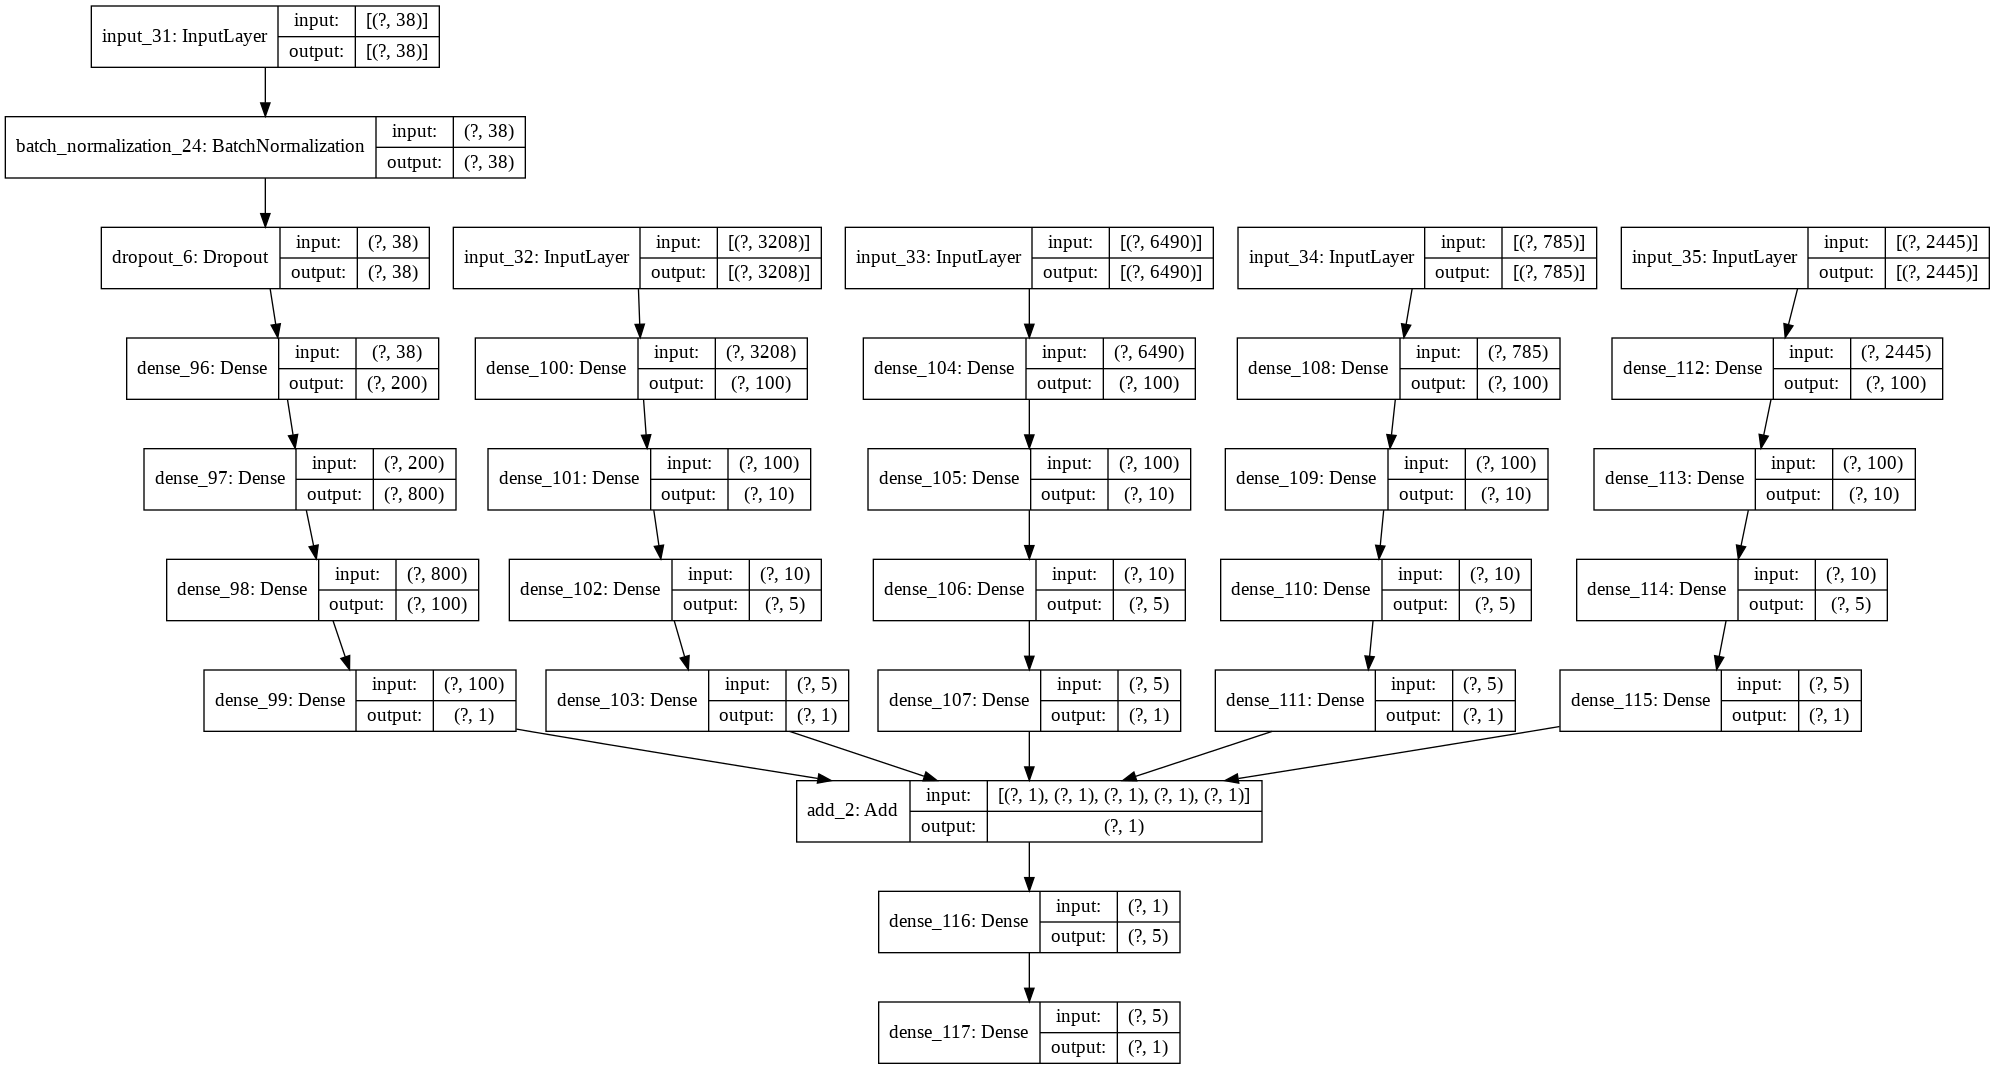

In [ ]:
# Используем все входы.

valSplit = 60000


neyronsNum = [[100, 10, 5, 1], [100, 10, 5, 1], [100, 10, 5, 1],
              [100, 10, 5, 1]]

input1 = Input((xTrain01.shape[1], ))
input2 = Input((xTrainProf01.shape[1], ))
input3 = Input((xTrainRez01.shape[1], ))
input4 = Input((xTrainCurPos01.shape[1], ))
input5 = Input((xTrainEdu01.shape[1], ))

x1 = BatchNormalization()(input1)
x1 = Dropout(0.5)(x1)
x1 = Dense(200, activation="relu")(x1)
x1 = Dense(800, activation="relu")(x1)
x1 = Dense(100, activation="relu")(x1)
x1 = Dense(1, activation='linear')(x1)

x2 = Dense(neyronsNum[0][0], activation="relu")(input2)
#x2 = BatchNormalization()(x2)
x2 = Dense(neyronsNum[0][1], activation="tanh")(x2)
x2 = Dense(neyronsNum[0][2], activation="relu")(x2)
x2 = Dense(neyronsNum[0][3], activation='linear')(x2)

x3 = Dense(neyronsNum[1][0], activation="relu")(input3)
#x3 = BatchNormalization()(x3)
x3 = Dense(neyronsNum[1][1], activation="tanh")(x3)
x3 = Dense(neyronsNum[1][2], activation="relu")(x3)
x3 = Dense(neyronsNum[1][3], activation='linear')(x3)

x4 = Dense(neyronsNum[2][0], activation="relu")(input4)
#x4 = BatchNormalization()(x4)
x4 = Dense(neyronsNum[2][1], activation="tanh")(x4)
x4 = Dense(neyronsNum[2][2], activation="relu")(x4)
x4 = Dense(neyronsNum[2][3], activation='linear')(x4)

x5 = Dense(neyronsNum[3][0], activation="relu")(input5)
#x5 = BatchNormalization()(x5)
x5 = Dense(neyronsNum[3][1], activation="tanh")(x5)
x5 = Dense(neyronsNum[3][2], activation="relu")(x5)
x5 = Dense(neyronsNum[3][3], activation='linear')(x5)

x = add([x1, x2, x3, x4, x5])

x = Dense(5, activation='linear')(x)
x = Dense(1, activation='linear')(x)

yScaler = StandardScaler()
yScaler.fit(yTrain.reshape(-1, 1))
yTrainScaled = yScaler.transform(yTrain.reshape(-1, 1))

model9 = Model((input1, input2, input3, input4, input5), x)

model9.compile(optimizer=Adam(lr=1e-3), loss='mse', metrics=['mae'])
utils.plot_model(model9, show_shapes=True)

In [ ]:
history9 = model9.fit([
    xTrain01[:valSplit], xTrainProf01[:valSplit], xTrainRez01[:valSplit],
    xTrainCurPos01[:valSplit], xTrainEdu01[:valSplit]
],
                      yTrainScaled[:valSplit],
                      epochs=10,
                      validation_data=([
                          xTrain01[valSplit:], xTrainProf01[valSplit:],
                          xTrainRez01[valSplit:], xTrainCurPos01[valSplit:],
                          xTrainEdu01[valSplit:]
                      ], yTrainScaled[valSplit:]),
                      verbose=1,
                      shuffle=True)

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.8622 - mae: 0.1981 - val_loss: 0.0985 - val_mae: 0.2029
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.8165 - mae: 0.1550 - val_loss: 0.0750 - val_mae: 0.1721
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.7909 - mae: 0.1306 - val_loss: 0.0686 - val_mae: 0.1607
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.7674 - mae: 0.1148 - val_loss: 0.0675 - val_mae: 0.1533
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.7428 - mae: 0.1087 - val_loss: 0.0655 - val_mae: 0.1524
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.7173 - mae: 0.1038 - val_loss: 0.0715 - val_mae: 0.1580
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.6801 - mae: 0.0966 - val_loss: 0.1024 - val_mae: 0.1911
Epoch 8/10
1875/1875 [==============================] - 8s 4ms

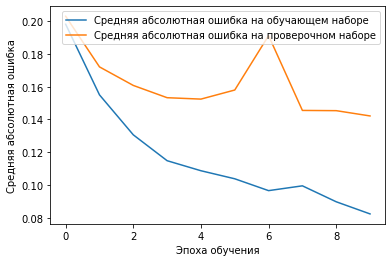

In [ ]:
# Графики
plotDraw(history9)

In [ ]:
# дообучение
model9.compile(optimizer=Adam(lr=5e-5), loss='mse', metrics=['mae'])

history9 = model9.fit([
    xTrain01[:valSplit], xTrainProf01[:valSplit], xTrainRez01[:valSplit],
    xTrainCurPos01[:valSplit], xTrainEdu01[:valSplit]
],
                      yTrainScaled[:valSplit],
                      epochs=10,
                      validation_data=([
                          xTrain01[valSplit:], xTrainProf01[valSplit:],
                          xTrainRez01[valSplit:], xTrainCurPos01[valSplit:],
                          xTrainEdu01[valSplit:]
                      ], yTrainScaled[valSplit:]),
                      verbose=1,
                      shuffle=True)

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4838 - mae: 0.0257 - val_loss: 0.0617 - val_mae: 0.1199
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4829 - mae: 0.0241 - val_loss: 0.0624 - val_mae: 0.1194
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4793 - mae: 0.0227 - val_loss: 0.0623 - val_mae: 0.1193
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4753 - mae: 0.0215 - val_loss: 0.0622 - val_mae: 0.1210
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4718 - mae: 0.0211 - val_loss: 0.0623 - val_mae: 0.1187
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4688 - mae: 0.0204 - val_loss: 0.0625 - val_mae: 0.1183
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4661 - mae: 0.0196 - val_loss: 0.0622 - val_mae: 0.1183
Epoch 8/10
1875/1875 [==============================] - 8s 4ms

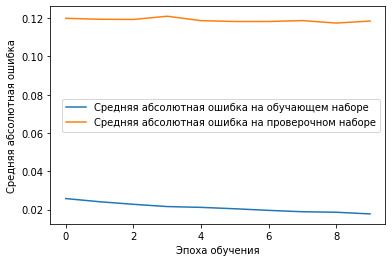

In [ ]:
# Графики
plotDraw(history9)

In [ ]:
# Сравнение предсказаний моделей
comparePredY(model9,[xTrain01, xTrainProf01, xTrainRez01, xTrainCurPos01, xTrainEdu01], yTrain)

![Результат работы НС](https://fs-th02.getcourse.ru/fileservice/file/thumbnail/h/cdba1211a7993027a5c26b521fc7f1e7.png/s/fx/a/84670/sc/179)

# **Сеть показывает прекрасные результаты**